# here is the analysiss of the processfile

In [1]:
import pandas as pd
pd.options.display.max_rows = 20
import numpy as np
import matplotlib.pyplot as plt
import collections
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from scipy import histogram, digitize, stats, mean, std
import sys
import statsmodels.api as sm
from sklearn import linear_model,preprocessing ,decomposition
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler #used custom one
from sklearn.linear_model import Lasso

In [2]:
test = pd.read_csv('./processed/stapled_peptide_permability_features.csv')
test = test[test['Peptide_type'] != 1].reset_index(drop=True)
test = test[test['sequence'] != '-AC-AHL-R8-LCLEKL-S5-GLV-(K-PEG1--FITC-)'].reset_index(drop=True)
test['Lg_Flr'] = np.log10(test['Mean_Flr_intensity'])


In [3]:
# function process sequence into list
def process_string(str,len=len):
    result = []
    special_resi = False
    for i in str:
        if i =='(':
            return len(result)
        elif special_resi and i !='-': #inside special residue
            temp += i
        elif i =='-':
            if special_resi : #closing of special residue
                result += [temp,]
                special_resi = False
                temp  = ''
            else: #starting of special residue
                special_resi = True 
                temp = ''
        else: #normal residue
            result += [i,]
            #if i in ['Q','N']:
                #result += [i,]
    return len(result)


In [4]:
# more features 
if True:
    test['len']=test['sequence'].apply(process_string)
    test['res_list']=test['sequence'].apply(lambda x : process_string(x,list))
    test['list']=test['sequence'].apply(lambda x : np.array(process_string(x,list)))
    test['res_list_QN']=test['res_list'].apply(lambda x : collections.Counter(x)['Q']+collections.Counter(x)['N'])
    test['res_list']=test['res_list'].apply(len)
    dictt = collections.Counter(np.concatenate(test['list'].values))
    test['Aro_Ccycle_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAromaticCarbocycles(Chem.MolFromSmiles(x)))
    test['Aro_Hcycle_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAromaticHeterocycles(Chem.MolFromSmiles(x)))
    test['Aro_Ring_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAromaticRings(Chem.MolFromSmiles(x)))
    test['Ali_Ccycle_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAliphaticCarbocycles(Chem.MolFromSmiles(x)))
    test['Ali_Hcycle_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAliphaticHeterocycles(Chem.MolFromSmiles(x)))
    test['Ali_Ring_num'] = test['SMILES'].apply(lambda x :\
        Descriptors.NumAliphaticRings(Chem.MolFromSmiles(x)))
    for i in [x for x in test.keys() if ('Ali' in x or 'Aro' in x)]:
        test[i[:-4]+'_norm'] = test[i]/test['res_list']
    test['TPSA-DIV-LabuteASA'] = test['TPSA']/test['LabuteASA'] #ratio of polar SA


def get_surface_area(smile):
    #print (smile[-25:])
    mol0 = Chem.MolFromSmiles(smile)
    mol = Chem.AddHs(mol0)
    AllChem.Compute2DCoords(mol)
    adj = (Chem.GetDistanceMatrix(mol)==1)*1
    adj2 = (Chem.GetDistanceMatrix(mol)==2)*1
    molMMFF = AllChem.MMFFGetMoleculeProperties(mol)
    # Chem.MolSurf._LabuteHelper(mol) indiv contribution of surface area
    atoms = list(
                            map(lambda x: molMMFF.GetMMFFAtomType(x),
                                range(len(mol.GetAtoms()))
                                 )
                            )
    AllChem.ComputeGasteigerCharges(mol)
    charges = np.array([float(mol.GetAtomWithIdx(x).GetProp('_GasteigerCharge')) for x in range(len(atoms))])
    surf= np.array(Chem.MolSurf._LabuteHelper(mol))
    return (charges,surf[1:],atoms)
test['charge_surf'] = test['SMILES'].apply( get_surface_area)
test['charge_num'] = test['charge_surf'].apply(lambda x : np.sum(x[0]))
test['charge_mean'] = test['charge_surf'].apply(lambda x : np.mean(x[0]))

#combine similar amino acids together
dictt_vol = {'FITC': 163.32732360530238, 'PEG2': 75.972, 'pff': 84.691, 'Y': 68.658, 'I': 47.901,
             'E': 50.492, 'A': 28.806, 'P': 40.74, 'L': 47.901, 'AC': 16.891, 'B8': 71.665, 'B88': 146.863,
             'S5': 53.418, 'BAla': 28.806, 'PEG': 58.128, 'S': 33.6, 'D': 44.127, 'EEA': 93.299, 'F': 63.863,
             'R8': 72.513, 'T': 39.965, 'R5': 50.236, 'NL': 47.901, 'N': 44.673, 'Q': 51.038, 'R88': 115.722,
             'S8': 72.513, 'C': 39.961, 'B5': 71.665, 'G': 22.441, 'K': 53.241, 'R': 63.476, 'PEG1': 58.128,
             'W': 79.754, 'M': 51.659, 'V': 35.171, 'PEG5': 135.867, 'H': 56.292}
for i in [('W','F','Y','pff'),('N','Q'),('L','I','V','NL'),('D','E'),
          ('S8','R8','B8'),('R5','S5'),('PEG2','PEG5','PEG1'),
          ('R','K'),('H','R','K'),('S','T'),('S8','R8'),('S8','B8'),('R8','B8'),
          ('W','F','pff'),('F','pff'),('F','Y')]:
    dictt[i] = 999

#feature for each aa groups
for res in dictt.keys():
        test['%s_num' %str(res)] = test['list'].apply(lambda x : sum(np.in1d(x,np.array(res))))
        test['%s_norm' %str(res)] = 1.0*test['%s_num'%str(res)]/test['res_list']
        test['%s_normSA' %str(res)] = test['list'].apply(lambda y: np.array(list(map(lambda x : dictt_vol[x],y)))).apply(np.sum) #total area
        test['%s_normSA' %str(res)] = test['list'].apply(lambda y : sum(np.array(list(map(lambda x : dictt_vol[x],y)))[np.in1d(y,np.array(res))]))\
                                      /test['list'].apply(lambda y: np.array(list(map(lambda x : dictt_vol[x],y)))).apply(np.sum)

print ('frequencies of each amino acid：',dictt)

frequencies of each amino acid： Counter({('S8', 'R8', 'B8'): 999, ('R', 'K'): 999, ('W', 'F', 'Y', 'pff'): 999, ('W', 'F', 'pff'): 999, ('S', 'T'): 999, ('L', 'I', 'V', 'NL'): 999, ('F', 'pff'): 999, ('H', 'R', 'K'): 999, ('R8', 'B8'): 999, ('F', 'Y'): 999, ('R5', 'S5'): 999, ('S8', 'B8'): 999, ('PEG2', 'PEG5', 'PEG1'): 999, ('S8', 'R8'): 999, ('D', 'E'): 999, ('N', 'Q'): 999, 'R': 545, 'L': 320, 'S5': 267, 'Q': 206, 'FITC': 193, 'E': 188, 'BAla': 172, 'A': 168, 'I': 142, 'F': 141, 'S': 132, 'N': 121, 'K': 119, 'V': 104, 'D': 103, 'T': 80, 'H': 73, 'R8': 65, 'W': 44, 'G': 43, 'S8': 42, 'B5': 36, 'Y': 34, 'P': 32, 'C': 26, 'M': 18, 'NL': 17, 'R5': 14, 'pff': 9, 'PEG2': 8, 'PEG5': 5, 'PEG1': 5, 'B8': 3, 'EEA': 3})


In [6]:
# Import pairwise2 module
from Bio import pairwise2

# Import format_alignment method
from Bio.pairwise2 import format_alignment
dictt_counter = {}
counter =0
# convert the amino acids into single letter for sequence anaylsis,as some amino acids contain  > 1 letters
string='abcdefghijklmnopqrstuvwxyz1234567890!@#$%^&*()'
for i in sorted(dictt,key=lambda x : dictt[x])[::-1]:
  if type(i) != tuple:  
    dictt_counter[i] = string[counter]
    counter += 1
def func(x):
    result = ''
    for i in x:
        result += dictt_counter[i]
    return result
test['string'] = test['list'].apply(func)


In [7]:
corr_mat = np.zeros((len(test),len(test)))
# Define two sequences to be aligned
for i in range(len(test)):
    for j in range(i,len(test)):
        alignments = pairwise2.align.globalms(test.iloc[i]['string'],
                                             test.iloc[j]['string'],
                                              2, -1, -0.5, -0.1)
        alignments = sorted(alignments,key= lambda x : x[-3])[-1]
        score = 2*np.sum(np.array(list(map(lambda x : x,alignments[0])))==np.array(list(map(lambda x : x,alignments[1]))))
        corr_mat[i,j] = score/(len(test.iloc[i]['string'])+len(test.iloc[j]['string']))
        corr_mat[j,i] = score/(len(test.iloc[i]['string'])+len(test.iloc[j]['string']))


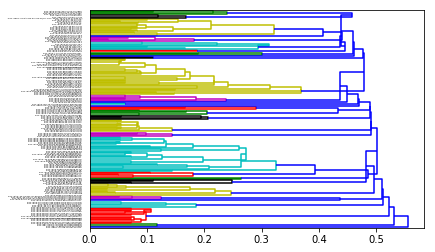

In [75]:
if True:
    import scipy.spatial.distance as ssd
    heat_map = abs(corr_mat-1)
    import scipy.cluster.hierarchy as sch
    from scipy.cluster.hierarchy import fcluster
    Y = sch.linkage(ssd.squareform(heat_map),method='centroid')
    Z = sch.dendrogram(Y,orientation='right')
    index = Z['leaves']
    D = heat_map[index,:]
    D = D[:,index]
    sorted_keys = [test.iloc[x]['sequence'] for x in index]
    plt.close()
    plt.xticks(range(len(index)),sorted_keys,rotation='vertical', fontsize=2)
    plt.yticks(range(len(index)),sorted_keys, fontsize=2)
    plt.imshow(D);plt.savefig('./figures/cluster_peptide.png',dpi=300, bbox_inches='tight');#plt.show()
    plt.close()
    Z = sch.dendrogram(Y,orientation='right')
    plt.yticks(np.array(range(1,1+len(index)))*10-5,sorted_keys, fontsize=2)
    plt.savefig('../reports/figures/cluster_peptide.png',dpi=300)
plt.show()

In [89]:
class StandardScaler(object):
    #custom weighted scale function
    def fit(self,X,weights):
        if type(weights)==type(None):
            mean = np.mean(X, 0).values
            std = np.std(X, 0).values
        else:
            weights= np.array([weights,]*X.shape[1]).T
            mean = np.sum(np.array(weights)*np.array(X),0)/np.sum(np.array(weights),0)
            std = np.sum(np.array(weights)*((np.array(X)-mean)**2),0)/np.sum(np.array(weights),0)
        self.mean = mean
        self.std = std
        return self
    def transform(self,X):
        return (X.values-self.mean)/self.std

def plot_LR_coefficient(results,cutoff,test):
    reg_coef = pd.DataFrame(results,columns= \
                            ['name','simple LR model R2','corr coef','Se','CI','present in ids']).\
                            sort_values('simple LR model R2').reset_index(drop=True)

    if True:
        for i in [x[:3] for x in sorted(results,key =  lambda x : x[0])[-250:]]:
                if i[2] > 0.01:
                        print (i[0][:-10],str(i[2])[:6],str(i[1])[0:5])
        for i in [x[:3] for x in sorted(results,key =  lambda x : x[0])[-250:]]:
                if i[2] < -0.01:
                        print (i[0][:-10],str(i[2])[:6],str(i[1])[0:6])
    features = []
    if True:
        plt.close()
        counter = 1
        plots = []
        for i in [x for x in sorted(results,key =  lambda x : x[-4])[-250:]]:
                if i[2] < -0.01 and 'num' in i[0] and '.(' not in i[0]:
                        features += [i[0],]
                        plots += [i,]
                        plt.errorbar([i[-4],],[counter,]*1,xerr=i[-3],fmt='r')
                        plt.plot([i[-4],],[counter,]*1,'ro')
                        if i[-4]-1.19*i[-3] > 0 or  i[-4]+1.19*i[-3] < 0:
                            txt = i[0]+'***'
                        elif i[-4]-i[-3] > 0 or i[-4]+i[-3] < 0:
                            txt = i[0]+'**'
                        else:
                            txt = i[0]+'*'
                        plt.text(i[-4],counter+.25,txt,horizontalalignment='center',fontsize=7)
                        counter += 1
        try:
            i = [x for x in sorted(results,key =  lambda x : x[-4]) if 'res_list' in x[0]][0]
            plots += [i,]
            plt.errorbar([i[-4],],[counter,]*1,xerr=i[-3],fmt='g')
            plt.plot([i[-4],],[counter,]*1,'go')
            if i[-4]-1.19*i[-3] > 0 or  i[-4]+1.19*i[-3] < 0:
                txt = i[0]+'***'
            elif i[-4]-i[-3] > 0 or i[-4]+i[-3] < 0:
                txt = i[0]+'**'
            else:
                txt = i[0]+'*'
            plt.text(i[-4],counter+.25,'Number of residues**',horizontalalignment='center',fontsize=7)
            counter += 1
        except : None
        for i in [x for x in sorted(results,key =  lambda x : x[-4])[-250:]]:
                if i[2] > 0.01 and 'num' in i[0] and '.(' not in i[0]:
                        features += [i[0],]
                        plots += [i,]
                        plt.errorbar([i[-4],],[counter,]*1,xerr=i[-3],fmt='b')
                        plt.plot([i[-4],],[counter,]*1,'bo')
                        if i[-4]-1.19*i[-3] > 0 or  i[-4]+1.19*i[-3] < 0:
                            txt = i[0]+'***'
                        elif i[-4]-i[-3] > 0 or i[-4]+i[-3] < 0:
                            txt = i[0]+'**'
                        else:
                            txt = i[0]+'*'
                        plt.text(i[-4],counter+.25,txt,horizontalalignment='center',fontsize=7)
                        counter += 1
        plt.title('Number Features')
        plt.xlabel('Coefficient and 95% CI of feature')
        plt.ylabel('Features')
        plt.yticks([],[])
        plt.ylim([0,counter])
        plt.savefig('../reports/figures/B_coef_cutoff:_'+str(cutoff)+'.png',dpi=300),plt.show()
        plt.close()
        counter = 1
        plots = []
        for i in [x for x in sorted(results,key =  lambda x : x[-4])[-250:]]:
                if i[2] < -0.01 and 'num' not in i[0] and 'list' not in i[0] and 'normSA' not in i[0] and 'VSA' not in i[0]:
                        features += [i[0],]
                        plots += [i,]
                        plt.errorbar([i[-4],],[counter,]*1,xerr=i[-3],fmt='r')
                        plt.plot([i[-4],],[counter,]*1,'ro')
                        if i[-4]-1.19*i[-3] > 0 or  i[-4]+1.19*i[-3] < 0:
                            txt = i[0]+'***'
                        elif i[-4]-i[-3] > 0 or i[-4]+i[-3] < 0:
                            txt = i[0]+'**'
                        else:
                            txt = i[0]+'*'
                        plt.text(i[-4],counter+.25,txt,horizontalalignment='center',fontsize=7)
                        counter += 1
        for i in [x for x in sorted(results,key =  lambda x : x[-4])[-250:]]:
                if i[2] > 0.01 and 'num' not in i[0] and 'list' not in i[0] and 'normSA' not in i[0] and 'VSA' not in i[0]:
                        features += [i[0],]
                        plots += [i,]
                        plt.errorbar([i[-4],],[counter,]*1,xerr=i[-3],fmt='b')
                        plt.plot([i[-4],],[counter,]*1,'bo')
                        if i[-4]-1.19*i[-3] > 0 or  i[-4]+1.19*i[-3] < 0:
                            txt = i[0]+'***'
                        elif i[-4]-i[-3] > 0 or i[-4]+i[-3] < 0:
                            txt = i[0]+'**'
                        else:
                            txt = i[0]+'*'
                        plt.text(i[-4],counter+.25,txt,horizontalalignment='center',fontsize=7)
                        counter += 1
        plt.ylim([0,counter])
        plt.title('Normalized (by seq length) Features')
        plt.xlabel('Coefficient and 95% CI of feature')
        plt.ylabel('Percentage Features')
        plt.yticks([],[])
        plt.savefig('../reports/figures/B_norm_cutoff:_'+str(cutoff)+'.png',dpi=300),plt.show()    


    dataA = []
    all_pred = []
    for seed in range(1,3):
        if seed ==1 :
            a,b = 0,1
        else:
            a,b = 1,0
        replace = False
        test1=test.sort_values(['weight','Mean_Flr_intensity']).iloc[a::2].reset_index(drop=True)
        test2=test.sort_values(['weight','Mean_Flr_intensity']).iloc[b::2].reset_index(drop=True)
        X,Y1,Y2 = [],[],[]
        for alpha in np.linspace(-5,-2,5)[-2:-1]:# [0.03,0.1,0.3,1.0,3.0]:
            alpha =10**alpha
            from scipy.optimize import minimize
            temptrain  = StandardScaler().fit(test1[features],weights=test1['weight']).transform(test1[features])
            X = np.concatenate([temptrain[:,0:1]*0+1,temptrain],1)
            B = np.zeros((X.shape[1],))
            W= test1[['weight',]].values
            y = test1[['Lg_Flr',]].values
            def weighted_lasso(B,X=X,y=y,W=W,alpha=alpha):
                B = np.reshape(B,(B.shape[0],1))
                score = W*(y-np.matmul(X,B))**2
                score = np.sum(score) /np.sum(W)
                score = score + np.sum(np.abs(B*alpha))
                return score
            B = minimize(weighted_lasso,B)['x']
            temptrain  = StandardScaler().fit(test1[features],weights=test1['weight']).transform(test1[features])
            X = np.concatenate([temptrain[:,0:1]*0+1,temptrain],1)
            preds = np.matmul(X,np.reshape(B,(1+len(features),1)))[:,0]
            temptrain  = StandardScaler().fit(test1[features],weights=test1['weight']).transform(test2[features])
            X = np.concatenate([temptrain[:,0:1]*0+1,temptrain],1)
            preds2 = np.matmul(X,np.reshape(B,(1+len(features),1)))[:,0]
            a,b=np.mean((preds -np.log10(test1['Mean_Flr_intensity']))**2)**.5,np.mean((preds2 -np.log10(test2['Mean_Flr_intensity']))**2)**.5
            print (alpha,a,b)
            X += [alpha,]
            Y1 += [a,]
            Y2 += [b,]    
            r1 = 1-np.mean((preds -test1['Lg_Flr'])**2)/np.mean((np.mean(test1['Lg_Flr']) -test1['Lg_Flr'])**2)
            r2 = str(np.corrcoef(preds2 ,np.log10(test2['Mean_Flr_intensity']))[0,1])[:4]#str(np.mean((preds2 -np.log10(test2['Mean_Flr_intensity']))**2)**.5)[:4]#str(1-np.mean((10**preds2 -test2['Mean_Flr_intensity'])**2)/np.mean((np.mean(test2['Mean_Flr_intensity']) -test2['Mean_Flr_intensity'])**2))[:4]
            dataA += [r2,]
            print (r2)
            print (alpha,a,b,r1,r2)
            if True:
                plt.plot([2.4,3.8],[2.4,3.8],'g',label='y = x');
                plt.plot(preds,np.log10(test1['Mean_Flr_intensity']),'ro',label='train predictions');
                plt.ylim([2.4,3.8]);plt.xlim([2.4,3.8]);
                plt.title('Combined_model\ncorr coef = %s'%r2);
                plt.xlabel('predictions of log flourescence');plt.ylabel('ground truth of log flourescence');
                plt.plot(preds2,np.log10(test2['Mean_Flr_intensity']),'bo',label='test predictions');#plt.legend()
                plt.savefig('../reports/figures/Combined_model_cutoff:_'+str(cutoff)+'.png');
                plt.show()


charge_surf
string
[("('W', 'F', 'pff')_num", 0.10964519229930869, 0.085642363343667954), ("('F', 'pff')_normSA", 0.11489607793132328, 0.0063720087837761301), ("('W', 'F', 'Y', 'pff')_normSA", 0.11949415516572404, 0.0076899122209175552), ("('F', 'pff')_norm", 0.12062025928709907, 0.0060100852018715092), ('D_norm', 0.12306045799860565, -0.0030438548070466803), ('D_num', 0.12927558895515867, -0.12600905918875197), ('D_normSA', 0.12946664134356767, -0.0024845838425390497), ('PEOE_VSA1', 0.13089631166147886, -4.7685854281508444), ('HBA', 0.13310052571540743, -0.93113017740679493), ("('W', 'F', 'Y', 'pff')_norm", 0.13327025887489652, 0.0073446478037507814), ('atom_8', 0.13525281130744482, -0.0092931149923466266), ("('W', 'F', 'pff')_normSA", 0.14050737225501098, 0.0070982595867098812), ('Aro_Ring_norm', 0.1493606004907142, 0.011601450540379548), ("('W', 'F', 'pff')_norm", 0.15014967946393676, 0.0066782964074674949), ('Aro_Ccycle_norm', 0.15542124001311075, 0.01158855533077156), ('HBA_norm',

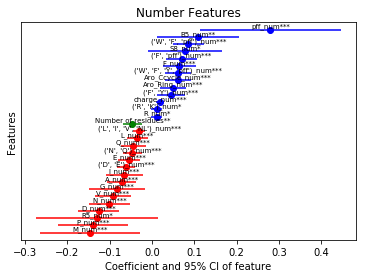

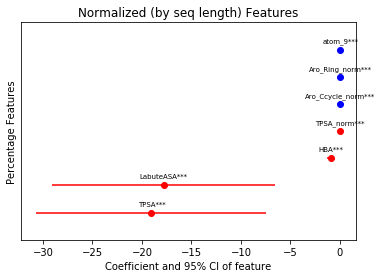

0.00177827941004 0.167218869891 0.215072671532
0.53
0.00177827941004 0.167218869891 0.215072671532 0.555701692921 0.53


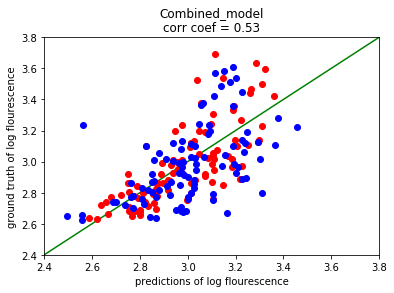

0.00177827941004 0.160973595153 0.211145938501
0.56
0.00177827941004 0.160973595153 0.211145938501 0.561975320994 0.56


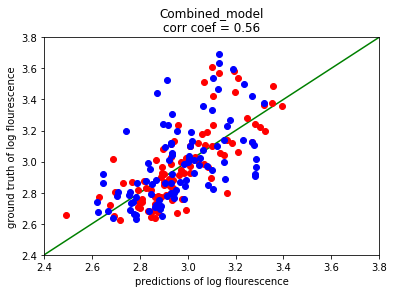

charge_surf
string
[('HBA_norm', 0.099596605390226522, -0.0010095194000553582), ('charge_std', 0.10118048800928914, -0.00063520472325111666), ("('F', 'Y')_norm", 0.10226320724653948, 0.0056811403872233579), ('TPSA_norm', 0.1063813851351969, -0.027158203892277397), ("('F', 'pff')_num", 0.1065051216676508, 0.075597017700647889), ("('W', 'F', 'Y', 'pff')_normSA", 0.10720421109806888, 0.0070999471265876879), ('Aro_Ring_norm', 0.10904109236671644, 0.0092992742954071464), ('atom_sum_8', 0.10978105513771064, -0.00098840702852621715), ("('W', 'F', 'pff')_num", 0.11116874016054579, 0.07865209215569724), ('F_normSA', 0.11747069755201578, 0.0055441214875557509), ("('W', 'F', 'Y', 'pff')_norm", 0.12277793444364893, 0.0067567118583853145), ('F_norm', 0.12912571872497858, 0.005349205825281653), ("('D', 'E')_num", 0.13047188365716944, -0.056550793145166901), ("('W', 'F', 'pff')_normSA", 0.13926352506869311, 0.0068425450385359021), ("('F', 'pff')_normSA", 0.14311111196800574, 0.0067624854390021753), (

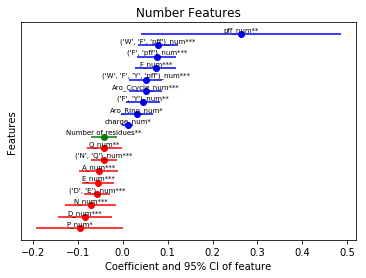

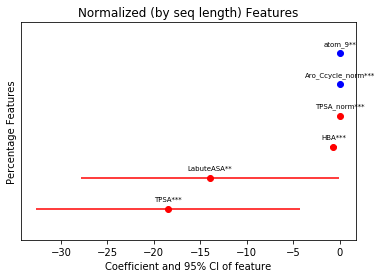

0.00177827941004 0.210793268008 0.221894196244
0.45
0.00177827941004 0.210793268008 0.221894196244 0.291686608385 0.45


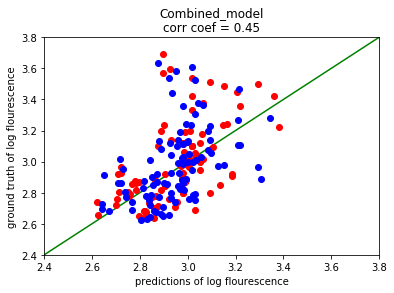

0.00177827941004 0.188349707221 0.246948655379
0.38
0.00177827941004 0.188349707221 0.246948655379 0.401815444255 0.38


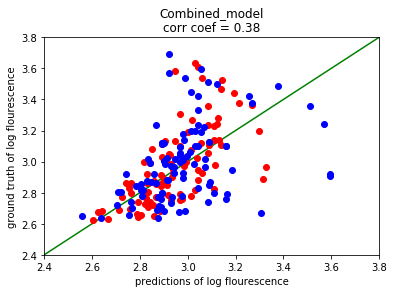

charge_surf
string
[('F_num', 0.11879967048288842, 0.082670341613917592), ("('F', 'Y')_norm", 0.11957723386045793, 0.0061604054081267519), ("('W', 'F', 'Y', 'pff')_normSA", 0.12023183811950899, 0.0075631782794982755), ('TPSA_norm', 0.12574307569042054, -0.028570352576536121), ('charge_std', 0.13204663153869545, -0.00072183587588768529), ("('F', 'pff')_num", 0.13303545165661823, 0.083373024347440622), ("('W', 'F', 'Y', 'pff')_norm", 0.13758832674049248, 0.0071711822007523851), ("('W', 'F', 'pff')_num", 0.13831527391798082, 0.085709092885169411), ('F_normSA', 0.13996325376635976, 0.0059619086337183392), ('atom_sum_8', 0.14056017176761804, -0.001023108972215186), ('HBA_norm', 0.14299563017497341, -0.0011141766216723398), ('Aro_Ccycle_norm', 0.14871516892663994, 0.010156302865343006), ('F_norm', 0.1514961430433579, 0.0057105964898352445), ("('D', 'E')_num", 0.15724075625821254, -0.070062188712681092), ("('W', 'F', 'pff')_normSA", 0.15790512845939497, 0.0071704332885508884), ("('F', 'pff')_

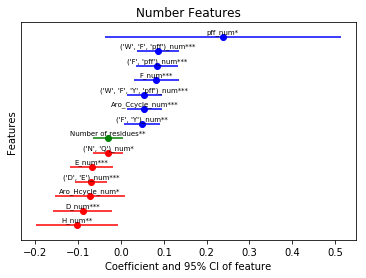

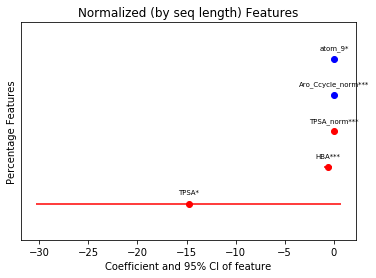

0.00177827941004 0.231890203627 0.240346573125
0.36
0.00177827941004 0.231890203627 0.240346573125 0.1408784025 0.36


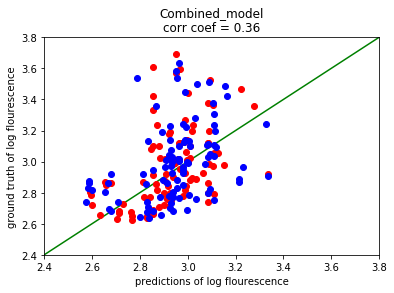

0.00177827941004 0.213331811099 0.247097079091
0.39
0.00177827941004 0.213331811099 0.247097079091 0.234390313854 0.39


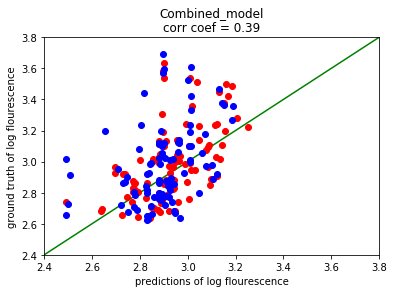

charge_surf
string
[('TPSA_norm', 0.14420640721651623, -0.030885306254763802), ("('W', 'F', 'Y', 'pff')_norm", 0.14678095930789847, 0.0075915846059352718), ('F_num', 0.14797531747418258, 0.096355323602543605), ('Aro_Ccycle_norm', 0.14928517238809158, 0.010566412646600602), ('E_norm', 0.15089207824664641, -0.0047221289869070942), ('E_normSA', 0.15266457323910143, -0.004455825892713797), ('charge_std', 0.16027218919355457, -0.00079804864573336813), ('F_normSA', 0.16342017365671491, 0.0065779418119978235), ("('W', 'F', 'pff')_num", 0.16457786228461779, 0.096751818878345455), ("('F', 'pff')_num", 0.16497327343462431, 0.097911913252505825), ('atom_sum_8', 0.16722583037478145, -0.0011470724973266942), ("('W', 'F', 'pff')_normSA", 0.16750713064425682, 0.007699001004401464), ('HBA_norm', 0.17068873422152131, -0.0012385142290913785), ('F_norm', 0.17657142682602289, 0.006261658794993707), ("('W', 'F', 'pff')_norm", 0.18522058906125116, 0.0072150607539710658), ("('F', 'pff')_normSA", 0.1864306514

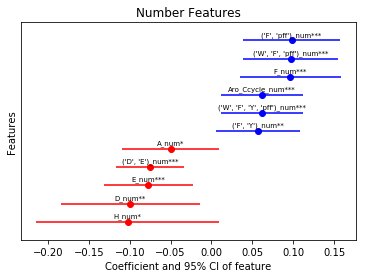

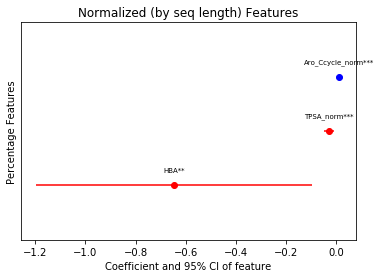

0.00177827941004 0.222616896373 0.249323566713
0.25
0.00177827941004 0.222616896373 0.249323566713 0.203375128216 0.25


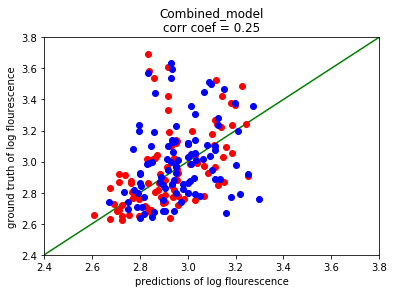

0.00177827941004 0.218271679595 0.235279832794
0.38
0.00177827941004 0.218271679595 0.235279832794 0.201641526113 0.38


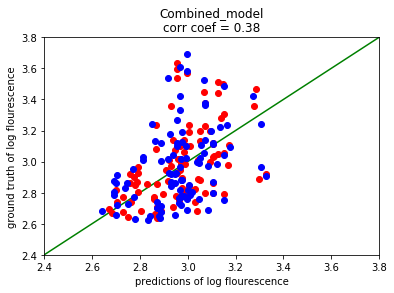

charge_surf
string
[("('F', 'Y')_norm", 0.1477263512553818, 0.0070710957204767593), ("('W', 'F', 'Y', 'pff')_normSA", 0.1484845701294667, 0.0088418339615003901), ('F_num', 0.15917313845818559, 0.088625519286803678), ('Aro_Ccycle_norm', 0.16203383562787732, 0.011278344094361095), ('HBA_norm', 0.1635010168377411, -0.001070875996332263), ("('W', 'F', 'Y', 'pff')_norm", 0.1678778697445239, 0.0083091736752568552), ('atom_sum_8', 0.17197204473426808, -0.0010311300497594308), ('F_normSA', 0.17290370314835068, 0.0069010322291438338), ("('F', 'pff')_num", 0.17486431351754939, 0.089262916827552705), ('TPSA-DIV-LabuteASA', 0.18749348332146176, -0.0093402514419184835), ('F_norm', 0.18867429690200543, 0.0065823294830732902), ("('W', 'F', 'pff')_num", 0.19258037884627333, 0.094366770867474845), ("('F', 'pff')_normSA", 0.19373249714444296, 0.0078442949344581653), ("('W', 'F', 'pff')_normSA", 0.19982432990642274, 0.0084158734648175186), ("('F', 'pff')_norm", 0.20498556605256002, 0.0073013082761095678)

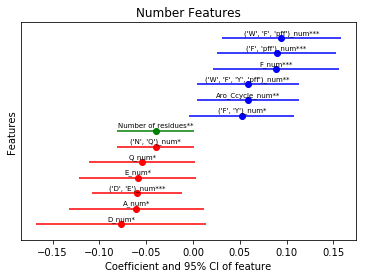

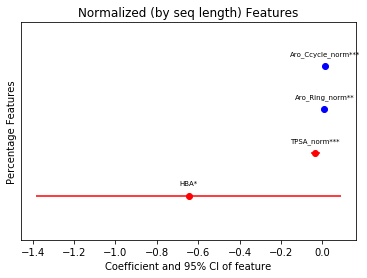

0.00177827941004 0.218698323081 0.224435885841
0.46
0.00177827941004 0.218698323081 0.224435885841 0.233760006201 0.46


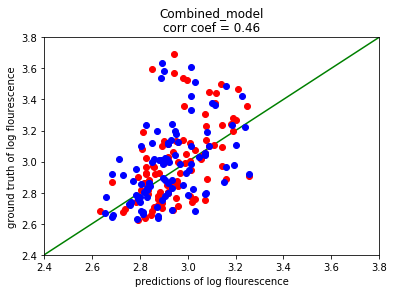

0.00177827941004 0.23213840533 0.241425771
0.36
0.00177827941004 0.23213840533 0.241425771 0.0949588980421 0.36


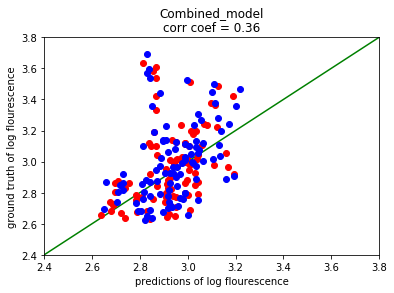

In [92]:
for cutoff in [0.01,0.1,0.15,0.2,0.3]:
    #weights for each cluster == 1     
    cluster = fcluster(Y, cutoff, criterion='distance')
    test = test.set_value(test.index,'weight0',cluster)
    test['weight'] = 1.0/test['weight0'].map(collections.Counter(fcluster(Y, cutoff, criterion='distance')))#1/(1+rho*(len(y)/(len(pd.unique(cluster))-1)))

    dictt = collections.Counter(np.concatenate(test['list'].values))

    for i in test.keys():
        try:
            if np.std(test[i])==0:
                del test[i]
        except : None
    dictt_name = {}
    if True:
        results = []
        for i in list(test.keys())[15:]:
            if 'weight' not in i:
                try:
                    X,Y1,Y2 = [],[],[]
                    clf = linear_model.LinearRegression()
                    temptrain  = StandardScaler().fit(test[[i,]],weights=test['weight']).transform(test[[i,]])
                    ids_non_zero = test[test[i]!=0].index
                    if 'num' in i or 'res_list' in i or i in ['atom_1', 'atom_6', 'atom_7', 'atom_8', 'atom_9', 'atom_16', 'atom_len', 'atom_size']: #do not scale count features. 
                        temptrain = test[[i,]].values #not scaled
                    temptrain2 = np.concatenate([temptrain*0+1,temptrain],1)
                    preds = clf.fit(temptrain,np.log10(test['Mean_Flr_intensity']),sample_weight=test['weight']).predict(temptrain)
                    # equailvalent ~ inv(X.T*W*X)*X.T*W*Y, analytic form of linear regression
                    W=np.diag(test['weight'])
                    X=temptrain2
                    y=np.log10(test['Mean_Flr_intensity'])
                    B=np.matmul(np.linalg.inv(np.matmul(np.matmul(X.T,W),X)) ,np.matmul(np.matmul(X.T,W),y))
                    preds = np.matmul(B,X.T)
                    se = np.sum(
                        (test['weight']*(preds-np.log10(test['Mean_Flr_intensity']))**2)
                        )*np.linalg.inv(
                             np.matmul(np.matmul(temptrain2.T,np.diag(test['weight'])),temptrain2)
                             )[-1,-1]
                    se = 2.0*(se/(sum(test['weight'])-2))**.5
        
                    if  (clf.coef_[0]-1.67*se/2 >0 or clf.coef_[0]+1.67*se/2  <0) and r2_score(np.log10(test['Mean_Flr_intensity']),preds,sample_weight=test['weight']) < 0.7:
                        dictt_name[i] = (i,r2_score(np.log10(test['Mean_Flr_intensity']),preds,sample_weight=test['weight']),
                                 clf.coef_[0],se,[clf.coef_[0]-se,clf.coef_[0]+se],ids_non_zero)
                        results += [(i,r2_score(np.log10(test['Mean_Flr_intensity']),preds,sample_weight=test['weight']),
                                     clf.coef_[0],se,[clf.coef_[0]-se,clf.coef_[0]+se],ids_non_zero)]

                except : print (i)
        print ([x[:3] for x in sorted(results,key =  lambda x : x[1])[-20:]])
        plot_LR_coefficient(results,cutoff,test)



In [91]:
list(test.keys())[15:]

['charge_kurtosis',
 'charge_std',
 'atom_1',
 'atom_sum_1',
 'atom_6',
 'atom_sum_6',
 'atom_7',
 'atom_sum_7',
 'atom_8',
 'atom_sum_8',
 'atom_9',
 'atom_sum_9',
 'atom_16',
 'atom_sum_16',
 'TPSA',
 'TPSA_norm',
 'LabuteASA',
 'LabuteASA_norm',
 'PEOE_VSA1',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'SMR_VSA1',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA9',
 'SMR_VSA10',
 'SlogP_VSA1',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA5',
 'SlogP_VSA6',
 'SlogP_VSA7',
 'SlogP_VSA8',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'VSA_EState4',
 'VSA_EState5',
 'VSA_EState8',
 'VSA_EState9',
 'VSA_EState10',
 'HBA',
 'HBD',
 'Rotatable_num',
 'HBA_norm',
 'HBD_norm',
 'atom_len',
 'atom_size',
 'permability',
 'Lg_Flr',
 'res_list',
 'res_list_QN',
 'Aro_Ccycle_num',
 'Aro_Hcycle_num',
 'Aro_Ring_num',
 'Ali_Hcycle_nu